In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime, sys, re, os
import pandas as pd

In [4]:
import csky as cy
import astropy
import healpy as hp
import histlite as hl
cy.plotting.mrichman_mpl()
soft_colors = cy.plotting.soft_colors

/mnt/lfs7/user/ssclafani/software/external/csky/csky/plotting.py:92: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\SetSymbolFont{operators}   {sans}{OT1}{cmss} {m}{n}'


In [5]:
import matplotlib as mpl

In [6]:
repo = cy.selections.Repository(local_root='/data/user/ssclafani/data/analyses')
ana_dir = cy.utils.ensure_dir('/data/user/ssclafani/data/analyses')
plot_dir = cy.utils.ensure_dir('/home/ssclafani/public_html/DNNCASACDE/plots/ps_sens')

In [7]:
specs = cy.selections.DNNCascadeDataSpecs.DNNC_11yr
ana = cy.analysis.Analysis (repo, specs)


Setting up Analysis for:
DNNCascade_2011_2021
Setting up DNNCascade_2011_2021...
Reading /data/user/ssclafani/data/analyses/DNNCascade/version-000-p01/IC86_2016_MC.npy ...
Reading /data/user/ssclafani/data/analyses/DNNCascade/version-000-p01/IC86_2011_2021_exp.npy ...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [8]:
decs = np.arange(-89, 89.1, 2)

In [9]:
base_dir = '/data/user/ssclafani/data/analyses/DNNC_11yr/ps/trials/ECAS'
sigfile = '{}/sig.dict'.format (base_dir)
sig = np.load (sigfile, allow_pickle=True)

bgfile = '{}/bg_chi2.dict'.format (base_dir)
bg = np.load (bgfile, allow_pickle=True)

In [10]:
def find_n_sig(dec, gamma=2.0, beta=0.9, nsigma=None, cutoff=None, verbose=False):
    # get signal trials, background distribution, and trial runner
    if cutoff == None:
        cutoff = np.inf
    if verbose:
        print(gamma, dec, cutoff)

    sig_trials = cy.bk.get_best(sig,  'gamma', gamma, 'cutoff_TeV', 
        cutoff, 'dec', dec, 'nsig')
    
    b = cy.bk.get_best(bg,  'dec', dec)
    if verbose:
        print(b)
    conf= {
    'src' : cy.sources(dec=dec, ra=0, deg=True),
    'flux' : cy.hyp.PowerLawFlux(gamma=gamma, energy_cutoff=cutoff*1e3)
            }
    tr = cy.get_trial_runner(ana=ana, conf=conf)
        # determine ts threshold
    if nsigma !=None:
        #print('sigma = {}'.format(nsigma))
        ts = b.isf_nsigma(nsigma)
    else:
        #print('Getting sensitivity')
        ts = cy.dists.Chi2TSD(b).median()
    if verbose:
        print(ts)

    # include background trials in calculation
    trials = {0: b}
    trials.update(sig_trials)
    #print(trials)
    
    #for key in trials.keys():
    #    trials[key] = trials[key].trials
    # get number of signal events
    # (arguments prevent additional trials from being run)

    result = tr.find_n_sig(ts, beta, max_batch_size=0, logging=verbose, trials=trials)
    flux = tr.to_E2dNdE(result['n_sig'], E0=100, unit=1e3)
    # return flux
    if verbose:
        print(ts, beta, result['n_sig'], flux)
    return flux #, result['n_sig']

In [11]:
build_sens = False
if build_sens:
    fluxs_E200 = []
    fluxs_E250 = []
    fluxs_E300 = []
    fluxs_E200_100TeVcutoff = []
    fluxs_E200_1PeVcutoff = []
    decs = np.arange(-89, 89.1, 2)
    for i, dec in enumerate(decs):
        print(dec)
        fluxs_E200.append(find_n_sig(dec, gamma=2.0, verbose=False))
        fluxs_E250.append(find_n_sig(dec, gamma=2.5, verbose=False))
        fluxs_E300.append(find_n_sig(dec, gamma=3.0, verbose=False))
        fluxs_E200_100TeVcutoff.append(find_n_sig(dec, gamma=2.0, cutoff=100))
        fluxs_E200_1PeVcutoff.append(find_n_sig(dec, gamma=2.0, cutoff=1e3))

    fluxs_E200 = np.array(fluxs_E200)
    fluxs_E250 = np.array(fluxs_E250)
    fluxs_E300 = np.array(fluxs_E300)
    fluxs_E200_100TeVcutoff = np.array(fluxs_E200_100TeVcutoff)
    fluxs_E200_1PeVcutoff = np.array(fluxs_E200_1PeVcutoff)
    print('SAVING!')
    np.save(base_dir + '/ps_sens_flux_E200.npy', fluxs_E200)
    np.save(base_dir + '/ps_sens_flux_E250.npy', fluxs_E250)
    np.save(base_dir + '/ps_sens_flux_E300.npy', fluxs_E300)
    np.save(base_dir + '/ps_sens_flux_E200_cutoff_100TeV.npy', fluxs_E200_100TeVcutoff)
    np.save(base_dir + '/ps_sens_flux_E200_cutoff_1PeV.npy', fluxs_E200_1PeVcutoff)

else:
    fluxs_E200 = np.load(base_dir + '/ps_sens_flux_E200.npy')
    fluxs_E250 = np.load(base_dir + '/ps_sens_flux_E250.npy')
    fluxs_E300 = np.load(base_dir + '/ps_sens_flux_E300.npy')
    fluxs_E200_100TeVcutoff = np.load(base_dir + '/ps_sens_flux_E200_cutoff_100TeV.npy')
    fluxs_E200_1PeVcutoff = np.load(base_dir + '/ps_sens_flux_E200_cutoff_1PeV.npy')

In [12]:
estes_E_minus2 = np.load('/data/user/smancina/PSSearches/ESTES_2019/CSky/ESTES2021_Sens_E-2.npy')
estes_sd = estes_E_minus2[0]
estes_flux = estes_E_minus2[1]
conf= {
'src' : cy.sources(dec=0, ra=0, deg=True),
'flux' : cy.hyp.PowerLawFlux(gamma=2, energy_cutoff=np.inf)
        }
tr = cy.get_trial_runner(ana=ana, conf=conf)
nss = [tr.to_ns(f, E0=1, unit=1e3) for f in estes_flux]
estes_E2dNdE = [tr.to_E2dNdE(n, E0 = 100, unit=1e3) for n in nss]

In [15]:
tracks_E2 = np.load('saved_sens/tracks_10yr_E2.npy')
sd_t = tracks_E2[::2]
tracks_flux_E2 = tracks_E2[1::2]

Reading /data/user/ssclafani/data/analyses/performance/sens_E200_MESE.tuple.npy ...
-> /home/ssclafani/public_html/DNNCASACDE/plots/ps_sens/ps_sens_E200_no_sources


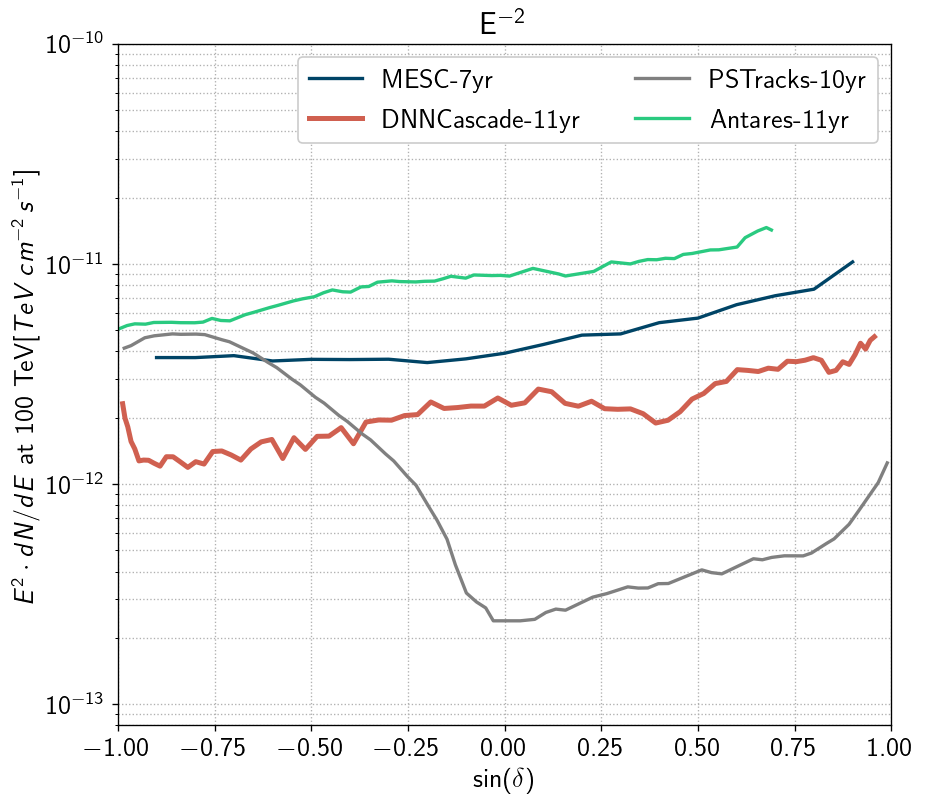

In [16]:
mpl.rc('font', size=16) 
fig, ax1 = plt.subplots (1, figsize=(8,7)) 
sd_m, phi_m = repo.get_performance('sens_E200_MESE')[:2]
ax1.semilogy (sd_m, phi_m,lw=2, c=soft_colors[0],  label=r'MESC-7yr')
ax1.semilogy(sorted(np.sin(np.radians(decs[4:-4]))), fluxs_E200[4:-4], 
             ls = '-', c=soft_colors[1], lw=3, label='DNNCascade-11yr')

#sd, phi = repo.get_performance ('sens_E200_ps10_current')[:2]
ax1.semilogy (sd_t, tracks_flux_E2, label=r'PSTracks-10yr', color='grey', ls='-')
antares_sens = pd.read_pickle('/data/user/ssclafani/data/analyses/catalogs/antares_E2.pickle')
sd_a = antares_sens['sindec']
phi_a = antares_sens['flux']
ax1.semilogy (sd_a, phi_a, label=r'Antares-11yr', color=soft_colors[2],lw=2,  ls='-')

#ax1.semilogy(estes_sd, estes_E2dNdE, label='ESTES 9yr', color=soft_colors[4], lw=2)

ax1.set_xlabel (r'$\sin(\delta)$')
ax1.set_ylabel (
    r'$E^2\cdot dN/dE$'
    r' at 100 TeV'
    r'[${TeV}\,{cm}^{-2}\,{s}^{-1}]$')
ax1.set_xlim (-1, 1)
ax1.grid(which='both')
ax1.set_ylim (.8e-13, 1e-10)
ax1.legend (ncol=2)
ax1.set_title('E$^{-2}$')
plt.tight_layout()
cy.plotting.saving(plot_dir, 'ps_sens_E200_no_sources')

In [17]:
exgal_srcs = np.load('/home/ssclafani/DNNCascade/catalogs/ExGalSourceList_ESTES_SENS_E200.npy')

In [18]:
ex_decs = exgal_srcs[0]
ex_fluxs = np.interp(np.sin(np.radians(ex_decs)), np.sin(np.radians(decs)), fluxs_E200)

-> /home/ssclafani/public_html/DNNCASACDE/plots/ps_sens/ps_sens_E200_sources


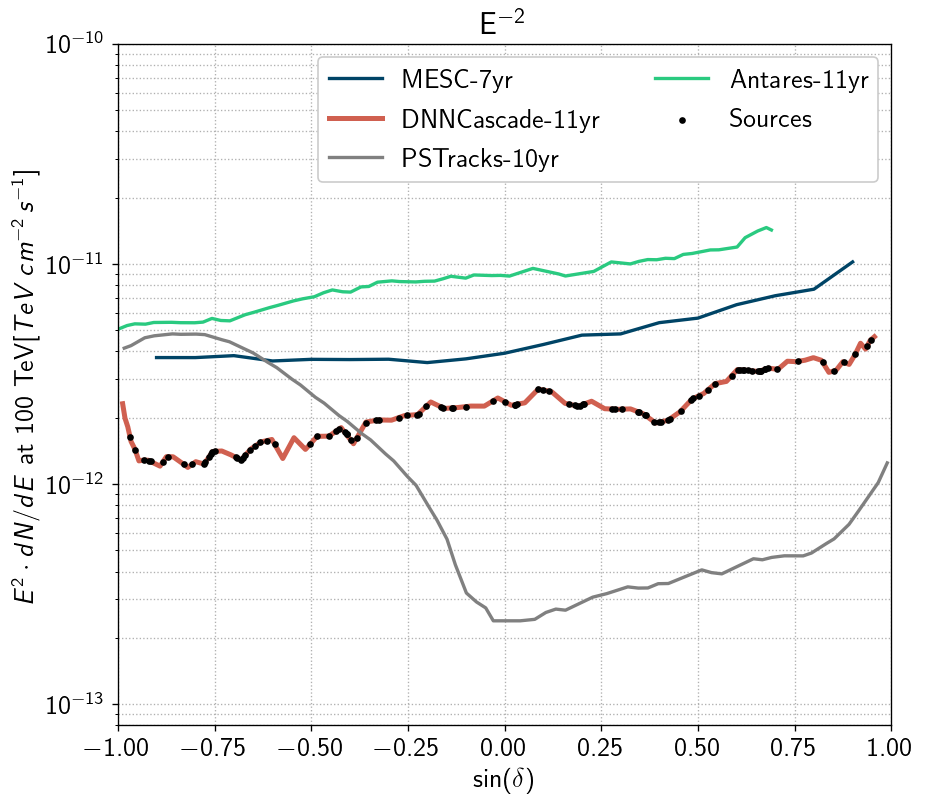

In [19]:
mpl.rc('font', size=16) 
fig, ax1 = plt.subplots (1, figsize=(8,7)) 
sd_m, phi_m = repo.get_performance('sens_E200_MESE')[:2]
ax1.semilogy (sd_m, phi_m,lw=2, c=soft_colors[0],  label=r'MESC-7yr')
ax1.semilogy(sorted(np.sin(np.radians(decs[4:-4]))), fluxs_E200[4:-4], 
             ls = '-', c=soft_colors[1], lw=3, label='DNNCascade-11yr')

#sd, phi = repo.get_performance ('sens_E200_ps10_current')[:2]
ax1.semilogy (sd_t, tracks_flux_E2, label=r'PSTracks-10yr', color='grey', ls='-')
antares_sens = pd.read_pickle('/data/user/ssclafani/data/analyses/catalogs/antares_E2.pickle')
sd_a = antares_sens['sindec']
phi_a = antares_sens['flux']
ax1.semilogy (sd_a, phi_a, label=r'Antares-11yr', color=soft_colors[2],lw=2,  ls='-')

ax1.scatter(np.sin(np.radians(ex_decs)), ex_fluxs, lw=1, color='k', marker='.', zorder=20, label='Sources')
ax1.set_xlabel (r'$\sin(\delta)$')
ax1.set_ylabel (
    r'$E^2\cdot dN/dE$'
    r' at 100 TeV'
    r'[${TeV}\,{cm}^{-2}\,{s}^{-1}]$')
ax1.set_xlim (-1, 1)
ax1.grid(which='both')
ax1.set_ylim (.8e-13, 1e-10)
ax1.legend (ncol=2)
ax1.set_title('E$^{-2}$')
plt.tight_layout()
cy.plotting.saving(plot_dir, 'ps_sens_E200_sources')

In [20]:
estes_E_minus2 = np.load('/data/user/smancina/PSSearches/ESTES_2019/CSky/ESTES2021_Sens_E-3.npy')
estes_sd = estes_E_minus2[0]
estes_flux = estes_E_minus2[1]
conf= {
'src' : cy.sources(dec=0, ra=0, deg=True),
'flux' : cy.hyp.PowerLawFlux(gamma=3, energy_cutoff=np.inf)
        }
tr = cy.get_trial_runner(ana=ana, conf=conf)
nss = [tr.to_ns(f, E0=1, unit=1e3) for f in estes_flux]
estes_E2dNdE = [tr.to_E2dNdE(n, E0 = 100, unit=1e3) for n in nss]

Reading /data/user/ssclafani/data/analyses/performance/sens_E300_MESE.tuple.npy ...
-> /home/ssclafani/public_html/DNNCASACDE/plots/ps_sens/ps_sens_E300_no_sources


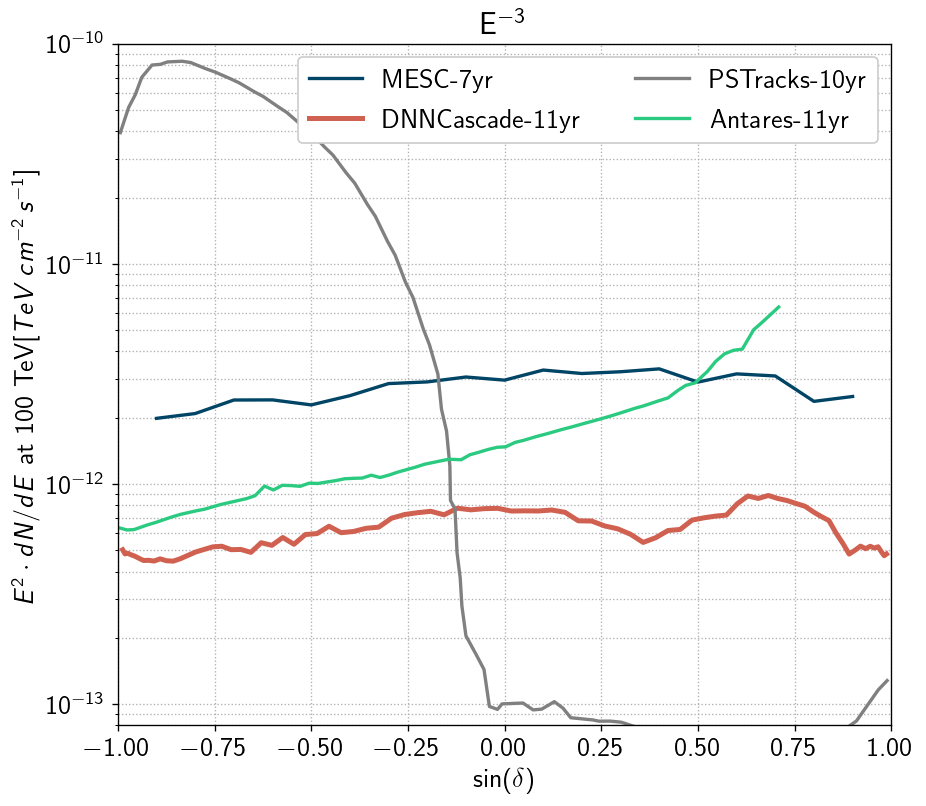

In [21]:
mpl.rc('font', size=16) 
fig, ax1 = plt.subplots (1, figsize=(8,7)) 

sd_m, phi_m = repo.get_performance('sens_E300_MESE')[:2]
ax1.semilogy (sd_m, phi_m,lw=2, c=soft_colors[0],  label=r'MESC-7yr')
ax1.semilogy(sorted(np.sin(np.radians(decs[4:-4]))), fluxs_E300[4:-4], 
             ls = '-', c=soft_colors[1], lw=3, label='DNNCascade-11yr')
tracks = pd.read_pickle('/data/user/ssclafani/data/analyses/catalogs/10yr_sens_E300.pickle')
sd = tracks['sindec']
E2dNdE = tracks['E2dNdE']
ax1.semilogy (sd, E2dNdE, label=r'PSTracks-10yr', color='grey', ls='-')


antares_sens = pd.read_pickle('/data/user/ssclafani/data/analyses/catalogs/antares_sens_E300.pickle')
sd = antares_sens['sindec']
e2dnde = antares_sens['E2dNdE']
ax1.semilogy(sd, e2dnde,  label=r'Antares-11yr', color=soft_colors[2],lw=2,  ls='-')

#ax1.semilogy(estes_sd, estes_E2dNdE, label='ESTES 9yr', color=soft_colors[4], lw=2)

ax1.set_xlabel (r'$\sin(\delta)$')
ax1.set_ylabel (
    r'$E^2\cdot dN/dE$'
    r' at 100 TeV'
    r'[${TeV}\,{cm}^{-2}\,{s}^{-1}]$')
ax1.set_xlim (-1, 1)
ax1.grid(which='both')
ax1.set_ylim (.8e-13, 1e-10)
ax1.legend (ncol=2)
ax1.set_title('E$^{-3}$')
plt.tight_layout()

cy.plotting.saving(plot_dir, 'ps_sens_E300_no_sources')

Reading /data/user/ssclafani/data/analyses/performance/sens_E250_MESE.tuple.npy ...
-> /home/ssclafani/public_html/DNNCASACDE/plots/ps_sens/ps_sens_E250_no_sources


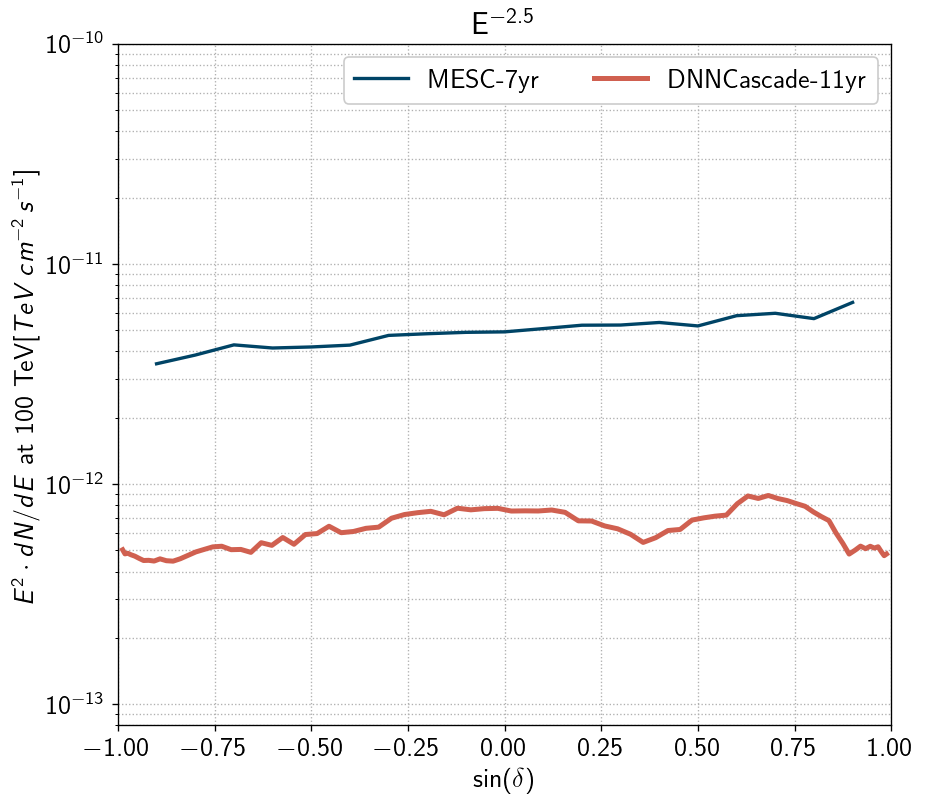

In [22]:
mpl.rc('font', size=16) 
fig, ax1 = plt.subplots (1, figsize=(8,7)) 

sd_m, phi_m = repo.get_performance('sens_E250_MESE')[:2]
ax1.semilogy (sd_m, phi_m,lw=2, c=soft_colors[0],  label=r'MESC-7yr')
ax1.semilogy(sorted(np.sin(np.radians(decs[4:-4]))), fluxs_E300[4:-4], 
             ls = '-', c=soft_colors[1], lw=3, label='DNNCascade-11yr')
#tracks = pd.read_pickle('/data/user/ssclafani/data/analyses/catalogs/10yr_sens_E300.pickle')
#sd = tracks['sindec']
#E2dNdE = tracks['E2dNdE']
#ax1.semilogy (sd, E2dNdE, label=r'PSTracks-10yr', color='grey', ls='-')


#antares_sens = pd.read_pickle('/data/user/ssclafani/data/analyses/catalogs/antares_sens_E300.pickle')
#sd = antares_sens['sindec']
#e2dnde = antares_sens['E2dNdE']
#ax1.semilogy(sd, e2dnde,  label=r'Antares-11yr', color=soft_colors[2],lw=2,  ls='-')

#ax1.semilogy(estes_sd, estes_E2dNdE, label='ESTES 9yr', color=soft_colors[4], lw=2)

ax1.set_xlabel (r'$\sin(\delta)$')
ax1.set_ylabel (
    r'$E^2\cdot dN/dE$'
    r' at 100 TeV'
    r'[${TeV}\,{cm}^{-2}\,{s}^{-1}]$')
ax1.set_xlim (-1, 1)
ax1.grid(which='both')
ax1.set_ylim (.8e-13, 1e-10)
ax1.legend (ncol=2)
ax1.set_title('E$^{-2.5}$')
plt.tight_layout()

cy.plotting.saving(plot_dir, 'ps_sens_E250_no_sources')

In [29]:
MESC_cutoff_Flux = np.load('saved_sens/MESC_sens_100TeV_cutoff.npy')
sd = MESC_cutoff_Flux[::2]
MESC_flux_100TeVcutoff = MESC_cutoff_Flux[1::2]

In [25]:
antares= [-0.9876522427310125, 9.441319436285771e-12,
-1.0072098793929252, 8.896278808190197e-12,
-0.953209071498644, 9.594230463244193e-12,
-0.9341947025217844, 9.678208301144843e-12,
-0.8931236655317676, 9.941795428126347e-12,
-0.8474891799873046, 1.0309435835186745e-11,
-0.8094604420335854, 1.033692516853843e-11,
-0.7592625079346761, 1.158816177891559e-11,
-0.7151491719083618, 1.1791910841934702e-11,
-0.6710358358820475, 1.1990531173438e-11,
-0.6269224998557332, 1.250537351247612e-11,
-0.5828091638294189, 1.3206472420641925e-11,
-0.537174678284956, 1.345820902024607e-11,
-0.491540192740493, 1.3665033529215598e-11,
-0.44590570719602995, 1.3986322924202649e-11,
-0.40179237116971556, 1.4469626964880728e-11,
-0.3576790351434014, 1.50836106153303e-11,
-0.31204454959893835, 1.5359969428238632e-11,
-0.2664100640544753, 1.5584697690205532e-11,
-0.22077557851001228, 1.5801234261780793e-11,
-0.17514109296554925, 1.610243119430851e-11,
-0.12950660742108622, 1.6266985284688367e-11,
-0.08387212187662318, 1.6385552480562725e-11,
-0.03823763633216015, 1.696681653391605e-11,
0.005875699694154246, 1.7572953992909763e-11,
0.04998903572046842, 1.8231613994880727e-11,
0.09562352126493145, 1.8837279731018468e-11,
0.13973685729124585, 1.9560683364357057e-11,
0.18537134283570889, 2.018931168705523e-11,
0.22948467886202306, 2.0898764340266142e-11,
0.27359801488833746, 2.1703085904383318e-11,
0.3207536499509491, 2.2197237943702194e-11,
0.36334583645911467, 2.3169018107926346e-11,
0.4089803220035777, 2.4236088245452966e-11,
0.451572508511743, 2.5611383720887138e-11,
0.49568584453805764, 2.718729874118477e-11,
0.5352357320099252, 2.932026023688193e-11,
0.5747856194817933, 3.16409809200577e-11,
0.6173778059899591, 3.449989457797988e-11,
0.6538853944255294, 3.820446862252359e-11,
0.687350683824802, 4.3050697908776633e-11]


In [ ]:
np.save('saved_sens/ANTARES_sens_100TeV_cutoff.npy', amtare)

In [30]:
antares_sd = antares[::2]
antares_flux = antares[1::2]

-> /home/ssclafani/public_html/DNNCASACDE/plots/ps_sens/ps_sens_E200_cutoff_no_sources


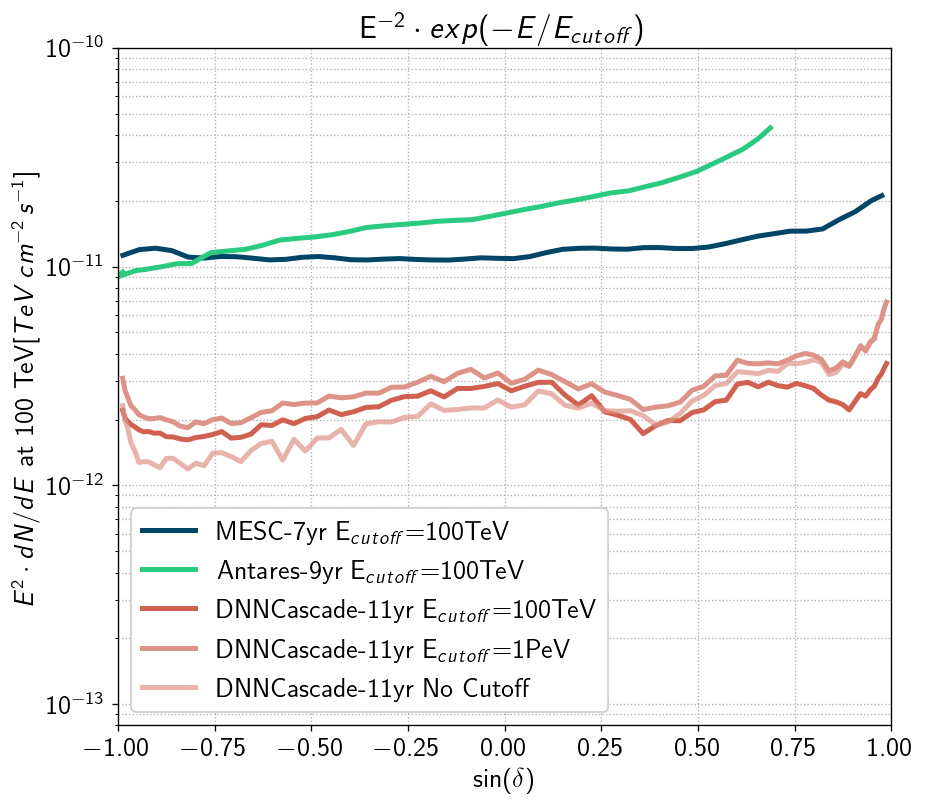

In [31]:
mpl.rc('font', size=16) 
fig, ax1 = plt.subplots (1, figsize=(8,7)) 

#sd_m, phi_m = repo.get_performance('sens_E200_100TeVCutoffMESE')[:2]
ax1.semilogy (sd, MESC_flux_100TeVcutoff,lw=3, c=soft_colors[0],  label=r'MESC-7yr E$_{cutoff}$=100TeV')
ax1.semilogy (antares_sd, antares_flux,lw=3, c=soft_colors[2],  label=r'Antares-9yr E$_{cutoff}$=100TeV')

ax1.semilogy(sorted(np.sin(np.radians(decs[4:-4]))), fluxs_E200_100TeVcutoff[4:-4], 
             ls = '-', c=soft_colors[1], lw=3, label='DNNCascade-11yr E$_{cutoff}$=100TeV')

ax1.semilogy(sorted(np.sin(np.radians(decs[4:-4]))), fluxs_E200_1PeVcutoff[4:-4], 
             ls = '-', c=soft_colors[3], lw=3, label='DNNCascade-11yr E$_{cutoff}$=1PeV')
ax1.semilogy(sorted(np.sin(np.radians(decs[4:-4]))), fluxs_E200[4:-4], 
             ls = '-', c=soft_colors[3], lw=3, alpha =.7,  label='DNNCascade-11yr No Cutoff')


ax1.set_xlabel (r'$\sin(\delta)$')
ax1.set_ylabel (
    r'$E^2\cdot dN/dE$'
    r' at 100 TeV'
    r'[${TeV}\,{cm}^{-2}\,{s}^{-1}]$')
ax1.set_xlim (-1, 1)
ax1.grid(which='both')
ax1.set_ylim (.8e-13, 1e-10)
ax1.legend (ncol=1)
ax1.set_title('E$^{-2} \cdot exp(-E/E_{cutoff})$')
plt.tight_layout()
cy.plotting.saving(plot_dir, 'ps_sens_E200_cutoff_no_sources')